#### Hi! Choosing a movie is a real struggle for many of us :) So most of the streaming platforms have inbuild recommendation systems. These systems aim to predict user's interests and recommend items that they'll probably like. Throughout this notebook, we will try to use 2 clasterisation methods to build our own movie recommender.

#### We are going to use three following data sets:
[Netflix TV Shows and Movies](https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies?datasetId=2178661&sortBy=voteCount)  
[HBO Max TV Shows and Movies](https://www.kaggle.com/datasets/victorsoeiro/hbo-max-tv-shows-and-movies?select=titles.csv)  
[Amazon Prime TV Shows and Movies](https://www.kaggle.com/datasets/victorsoeiro/amazon-prime-tv-shows-and-movies?select=titles.csv)  

<a id="1"></a> <br>
# Data and Library Imports

### Library Imports

In [60]:
import pandas as pd
import numpy as np
%precision %.4f

import warnings
warnings.filterwarnings('ignore')

# visualisation
import seaborn as sns
sns.set(style="whitegrid")
from matplotlib import pyplot as plt
%matplotlib inline
# import missingno as msno

# sklearn
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

### Data imports

In [61]:
df_netflix = pd.read_csv('Netflix TV Shows and Movies/titles.csv')
df_amazon =  pd.read_csv('Amazon Prime TV Shows and Movies/titles.csv')
df_hbo =  pd.read_csv('HBO Max TV Shows and Movies/titles.csv')

In [62]:
df = pd.concat([df_netflix, df_amazon, df_hbo], axis=0)

In [63]:
df_movies = df.drop_duplicates()

<a id="2"></a> <br>
# Exploratory Data Analysis

#### As the introduction to the data, let's take a look at the first 5 rows and the main characteristics of the dataset.


In [64]:
df_movies.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


#### We can already notice that some of the variables are missing data. Let's count the number of null and missing rows.

In [65]:
df_movies.isna().sum()

id                          0
title                       1
type                        0
description               149
release_year                0
age_certification       10296
runtime                     0
genres                      0
production_countries        0
seasons                 14772
imdb_id                  1394
imdb_score               1873
imdb_votes               1910
tmdb_popularity           670
tmdb_score               2656
dtype: int64

#### As we see, couple of variables have big gaps here.  
#### We're going to take a closer look at some of the variables.

### #1 type

In [66]:
df_movies.type.value_counts()

type
MOVIE    14772
SHOW      4208
Name: count, dtype: int64

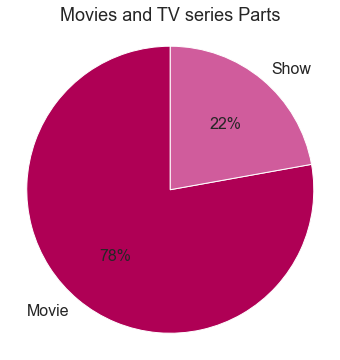

In [67]:
plt.figure(figsize=(10,6))
plt.title('Movies and TV series Parts', fontsize=18)
plt.pie(df_movies.type.value_counts(), 
        labels=['Movie', 'Show'],
        textprops={"fontsize":16},
        radius=1.1, startangle=90,
        colors=['#af0055', '#D05C9C'],
        autopct='%.0f%%')
plt.show()

In [68]:
df_movies.drop('description', axis=1, inplace=True)

### #3 release_year

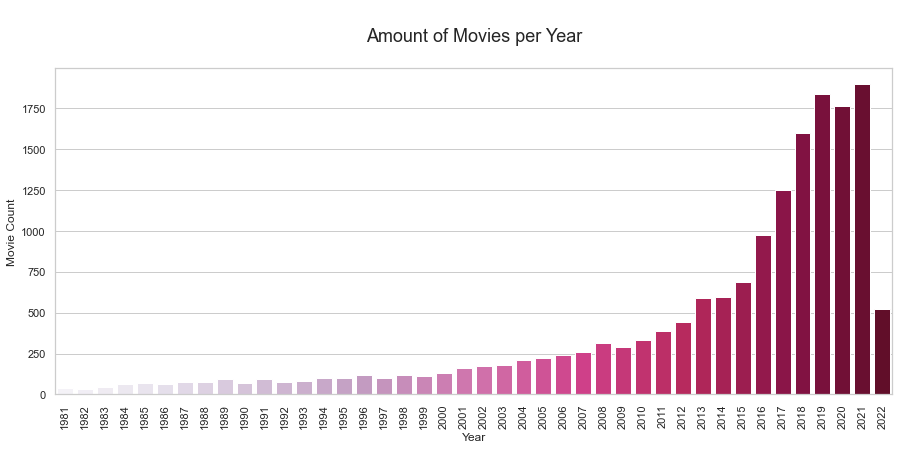

In [69]:
plt.figure(figsize=(15,6))
plt.title('\nAmount of Movies per Year\n', fontsize=18)
sns.countplot(df_movies[df_movies.release_year>1980].release_year, palette='PuRd')
plt.xticks(rotation=90)
plt.xlabel("Year")
plt.ylabel("Movie Count")
plt.show()

### #4 age_certification

In [70]:
print('NaN values in age sertification variable:', df_movies.age_certification.isna().sum())
print('This is', round(df_movies.age_certification.isna().sum()/df_movies.age_certification.shape[0]*100),'% of all the values')

NaN values in age sertification variable: 10296
This is 54 % of all the values


#### This variable contains too many undefined values, which cannot be filled in at the moment, so it was decided to drop it.

In [71]:
df_movies.drop('age_certification', axis=1, inplace=True)

### #5,6 production_countries and genres

#### These two variables are represented as lists.

#### Therefore, before working with them, the lists must be "unpacked" to strings. We'll also get a single "top" category of a list.

In [72]:
df_movies.head()

,id,title,type,release_year,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,1945,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,1976,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,1972,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,1975,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,1967,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [73]:
df_movies['production_countries'] = df_movies['production_countries'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')
df_movies['lead_prod_country'] = df_movies['production_countries'].str.split(',').str[0]

# Let's also add a number of countries, envolved in movie making, so that we save a little more data
df_movies['prod_countries_cnt'] = df_movies['production_countries'].str.split(',').str.len()

In [74]:
df_movies.lead_prod_country = df_movies.lead_prod_country.replace('', np.nan)

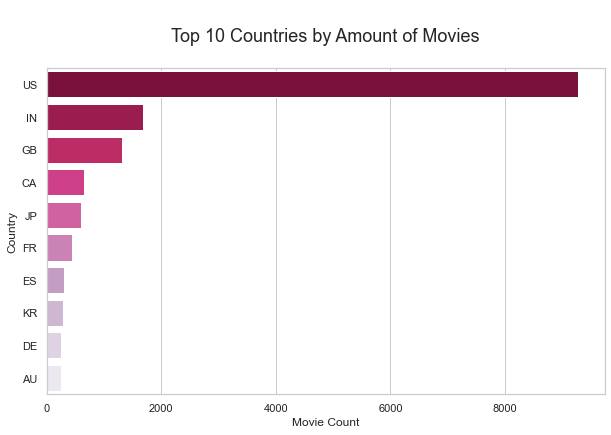

In [75]:
bp_df = pd.DataFrame(df_movies.lead_prod_country.value_counts()).head(10)
order = bp_df.index
plt.figure(figsize=(10,6))
plt.title('\nTop 10 Countries by Amount of Movies\n', fontsize=18)
sns.countplot(y=df_movies.lead_prod_country, palette='PuRd_r', order=order)
plt.xlabel('Movie Count')
plt.ylabel('Country')
plt.show()

#### Similar transformations we'll perform for genre: unpacking the list and leaving one main genre.

In [76]:
df_movies['genres'] = df_movies['genres'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')
df_movies['main_genre'] = df_movies['genres'].str.split(',').str[0]

In [77]:
df_movies.drop(['genres', 'production_countries'], axis=1, inplace=True)

#### Let's check out the result

In [78]:
df_movies.head()

,id,title,type,release_year,runtime,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,lead_prod_country,prod_countries_cnt,main_genre
0,ts300399,Five Came Back: The Reference Films,SHOW,1945,51,1.0,NaN,NaN,NaN,0.600,NaN,US,1,documentation
1,tm84618,Taxi Driver,MOVIE,1976,114,NaN,tt0075314,8.2,808582.0,40.965,8.179,US,1,drama
2,tm154986,Deliverance,MOVIE,1972,109,NaN,tt0068473,7.7,107673.0,10.010,7.300,US,1,drama
3,tm127384,Monty Python and the Holy Grail,MOVIE,1975,91,NaN,tt0071853,8.2,534486.0,15.461,7.811,GB,1,fantasy
4,tm120801,The Dirty Dozen,MOVIE,1967,150,NaN,tt0061578,7.7,72662.0,20.398,7.600,GB,2,war


In [79]:
df_movies['main_genre'].unique()

array(['documentation', 'drama', 'fantasy', 'war', 'comedy', 'thriller',
       'crime', 'romance', 'action', 'western', 'history', 'music',
       'horror', 'scifi', 'animation', 'family', 'reality', '', 'sport',
       'european'], dtype=object)

#### After the transformation, the strings that contained missing values left us an empty genre.
#### Let's fill it with NaN, in order to make it easier to deal with in the future.

In [80]:
df_movies.main_genre = df_movies.main_genre.replace('', np.nan)

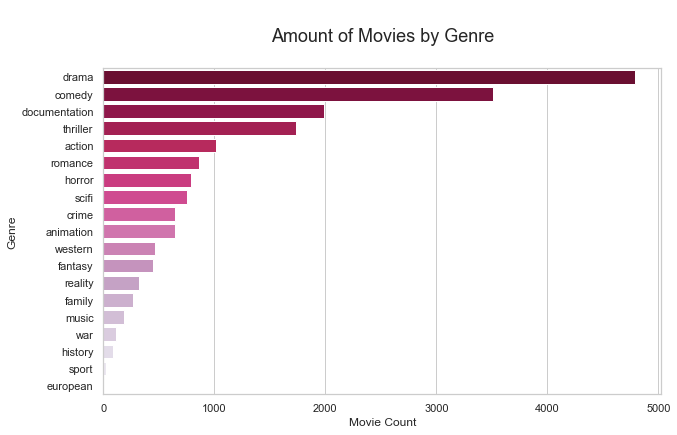

In [81]:
bp_df = pd.DataFrame(df_movies.main_genre.value_counts())
order = bp_df.index
plt.figure(figsize=(10,6))
plt.title('\nAmount of Movies by Genre\n', fontsize=18)
sns.countplot(y=df_movies.main_genre, palette='PuRd_r', order=order)
plt.xlabel('Movie Count')
plt.ylabel('Genre')
plt.show()

### #7 seasons

In [82]:
df_movies.head()

,id,title,type,release_year,runtime,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,lead_prod_country,prod_countries_cnt,main_genre
0,ts300399,Five Came Back: The Reference Films,SHOW,1945,51,1.0,NaN,NaN,NaN,0.600,NaN,US,1,documentation
1,tm84618,Taxi Driver,MOVIE,1976,114,NaN,tt0075314,8.2,808582.0,40.965,8.179,US,1,drama
2,tm154986,Deliverance,MOVIE,1972,109,NaN,tt0068473,7.7,107673.0,10.010,7.300,US,1,drama
3,tm127384,Monty Python and the Holy Grail,MOVIE,1975,91,NaN,tt0071853,8.2,534486.0,15.461,7.811,GB,1,fantasy
4,tm120801,The Dirty Dozen,MOVIE,1967,150,NaN,tt0061578,7.7,72662.0,20.398,7.600,GB,2,war


#### As we see, variable seasons has so many NaN values, because movies do not have seasons. Let's put a 0 here.

In [83]:
df_movies.loc[df_movies['type'] == 'MOVIE', ['seasons']] = 0

<a id="3"></a> <br>
# Feature Engeneeruing

#### Okay, seems like data is more or less clean. Now we're going to transform it for the future clusterisation models.


In [84]:
df_movies.isna().sum()

id                       0
title                    1
type                     0
release_year             0
runtime                  0
seasons                  0
imdb_id               1394
imdb_score            1873
imdb_votes            1910
tmdb_popularity        670
tmdb_score            2656
lead_prod_country     1160
prod_countries_cnt       0
main_genre             321
dtype: int64

#### And starting with getting rid of some NaN value that are still left in our dataset.

In [85]:
df_movies.dropna(inplace=True)

#### Also, set the name of the movie as an index

In [86]:
df_movies.set_index('title', inplace=True)
df_movies.head()

,id,type,release_year,runtime,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,lead_prod_country,prod_countries_cnt,main_genre
title,,,,,,,,,,,,,
Taxi Driver,tm84618,MOVIE,1976,114,0.0,tt0075314,8.2,808582.0,40.965,8.179,US,1,drama
Deliverance,tm154986,MOVIE,1972,109,0.0,tt0068473,7.7,107673.0,10.010,7.300,US,1,drama
Monty Python and the Holy Grail,tm127384,MOVIE,1975,91,0.0,tt0071853,8.2,534486.0,15.461,7.811,GB,1,fantasy
The Dirty Dozen,tm120801,MOVIE,1967,150,0.0,tt0061578,7.7,72662.0,20.398,7.600,GB,2,war
Monty Python's Flying Circus,ts22164,SHOW,1969,30,4.0,tt0063929,8.8,73424.0,17.617,8.306,GB,1,comedy


#### Now let's drop variables that don't have any semantic load -- the ID of the movies and TV shows on different platforms.

In [87]:
df_movies.drop(['id', 'imdb_id'], axis=1, inplace=True)

In [88]:
df_movies.dtypes

type                   object
release_year            int64
runtime                 int64
seasons               float64
imdb_score            float64
imdb_votes            float64
tmdb_popularity       float64
tmdb_score            float64
lead_prod_country      object
prod_countries_cnt      int64
main_genre             object
dtype: object

#### For the three categorical variables that we have now, we create dummy variable -- to represent them as 1s and 0s

In [89]:
dummies = pd.get_dummies(df_movies[['type', 'lead_prod_country', 'main_genre']], drop_first=True)
df_movies_dum = pd.concat([df_movies, dummies], axis=1)
df_movies_dum.drop(['type', 'lead_prod_country', 'main_genre'], axis=1, inplace=True)

#### Now rescale all the variables, so that they fit between 0 and 1

In [90]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_movies_dum)
df_scaled = pd.DataFrame(df_scaled, columns=[df_movies_dum.columns])
df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
release_year,14855.0,0.845746,0.205678,0.0,0.827273,0.936364,0.972727,1.0
runtime,14855.0,0.260577,0.106555,0.0,0.182927,0.274390,0.320122,1.0
seasons,14855.0,0.011753,0.039719,0.0,0.000000,0.000000,0.000000,1.0
imdb_score,14855.0,0.592880,0.143532,0.0,0.500000,0.602273,0.693182,1.0
imdb_votes,14855.0,0.010198,0.040940,0.0,0.000146,0.000653,0.003660,1.0
...,...,...,...,...,...,...,...,...
main_genre_scifi,14855.0,0.044362,0.205905,0.0,0.000000,0.000000,0.000000,1.0
main_genre_sport,14855.0,0.000808,0.028411,0.0,0.000000,0.000000,0.000000,1.0
main_genre_thriller,14855.0,0.100909,0.301218,0.0,0.000000,0.000000,0.000000,1.0
main_genre_war,14855.0,0.006328,0.079298,0.0,0.000000,0.000000,0.000000,1.0


In [91]:
df_scaled.shape

(14855, 146)

#### After the encoding we've got 146 variables, which is a relatevely big number. Let's use principal component analysis and see, if we can reduce number of features without much quality loss.

In [92]:
from sklearn.decomposition import PCA

pca = PCA(n_components=143, svd_solver='full')
df_scaled_full = pca.fit(df_scaled).transform(df_scaled)

explained_variance = np.round(np.cumsum(pca.explained_variance_ratio_),3)

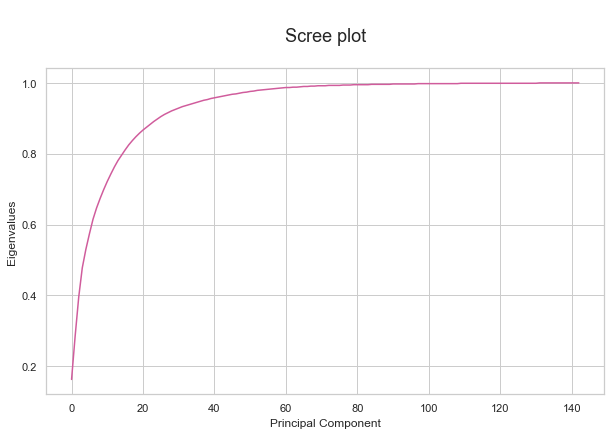

In [93]:
plt.figure(figsize=(10,6))
plt.title('\nScree plot\n', fontsize=18)
plt.plot(np.arange(143), explained_variance, color='#D05C9C')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalues')
plt.show()

In [94]:
# As we can see from the scree plot, it will be absolutely safe to decrese number of variables to 60, without almost no quality loss.¶

pca_60 = PCA(n_components=60, svd_solver='full')
df_scaled_60 = pca.fit(df_scaled).transform(df_scaled)

<a id="5"></a> <br>
# DBSCAN 

In [95]:
from sklearn.decomposition import PCA
pca_10d = PCA(n_components=10)
PCs_10d = pd.DataFrame(pca_10d.fit_transform(df_scaled_60))

eps_array = [0.2, 0.5, 1]
min_samples_array = [5, 10, 30]

In [96]:
for eps in eps_array:
  for min_samples in min_samples_array:
    clusterer = DBSCAN(eps=eps, min_samples=min_samples).fit(PCs_10d)
    cluster_labels = clusterer.labels_
    if len(set(cluster_labels)) == 1:
        continue
    silhouette_avg = silhouette_score(PCs_10d, cluster_labels)
    print("For eps =", eps,
          "For min_samples =", min_samples,
          "Count clusters =", len(set(cluster_labels)),
          "The average silhouette_score is :", silhouette_avg)

For eps = 0.2 For min_samples = 5 Count clusters = 64 The average silhouette_score is : 0.7658888786909586
For eps = 0.2 For min_samples = 10 Count clusters = 59 The average silhouette_score is : 0.7683358679013843
For eps = 0.2 For min_samples = 30 Count clusters = 49 The average silhouette_score is : 0.7622475287877991
For eps = 0.5 For min_samples = 5 Count clusters = 49 The average silhouette_score is : 0.7503039712249246
For eps = 0.5 For min_samples = 10 Count clusters = 47 The average silhouette_score is : 0.7490704165338906
For eps = 0.5 For min_samples = 30 Count clusters = 39 The average silhouette_score is : 0.740143430378516


In [97]:
dbscan10d_model = DBSCAN(eps=0.2, min_samples=10).fit(PCs_10d)
print("For eps =", 0.2,
      "For min_samples =", 10,
      "Count clusters =", len(set(dbscan10d_model.labels_)),
      "The average silhouette_score is :", silhouette_score(PCs_10d, dbscan10d_model.labels_))

For eps = 0.2 For min_samples = 10 Count clusters = 59 The average silhouette_score is : 0.7683358679013843


#### 10 Dimentions DBSCAN shows an acceptable score of 0.768. Guess, we can work with that.
#### Let's put the clustering results in the initial movies table.

In [98]:
df_movies['dbscan_10d_clusters'] = dbscan10d_model.labels_

In [59]:
df_movies

,type,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,lead_prod_country,prod_countries_cnt,main_genre,dbscan_10d_clusters
title,,,,,,,,,,,,
Taxi Driver,MOVIE,1976,114,0.0,8.2,808582.0,40.965,8.179,US,1,drama,0
Deliverance,MOVIE,1972,109,0.0,7.7,107673.0,10.010,7.300,US,1,drama,0
Monty Python and the Holy Grail,MOVIE,1975,91,0.0,8.2,534486.0,15.461,7.811,GB,1,fantasy,1
The Dirty Dozen,MOVIE,1967,150,0.0,7.7,72662.0,20.398,7.600,GB,2,war,1
Monty Python's Flying Circus,SHOW,1969,30,4.0,8.8,73424.0,17.617,8.306,GB,1,comedy,2
...,...,...,...,...,...,...,...,...,...,...,...,...
Covid Diaries NYC,MOVIE,2021,40,0.0,3.7,184.0,5.720,5.900,US,1,documentation,42
Breathless,MOVIE,2021,106,0.0,6.3,27.0,69.940,5.900,DO,1,crime,9
Furry Friends Forever: Elmo Gets a Puppy,MOVIE,2021,26,0.0,6.8,14.0,0.994,10.000,US,1,animation,5


<a id="6"></a> <br>
# Movie Recommendation Function

#### Our data is ready to use the clustering results to try and recommend a movie by the name of the one you like

In [99]:
import random

def recommend_movie(movie_name: str):
    # Convert the input movie name to lowercase for case-insensitive matching
    movie_name = movie_name.lower()

    # Create a new column 'name' with lowercase movie names for comparison
    df_movies['name'] = df_movies.index.str.lower()

    # Find the movie that matches the input name
    movie = df_movies[df_movies['name'].str.contains(movie_name, na=False)]

    if not movie.empty:
        # Get the cluster label of the input movie
        cluster = movie['dbscan_10d_clusters'].values[0]

        # Get all movies in the same cluster
        cluster_movies = df_movies[df_movies['dbscan_10d_clusters'] == cluster]

        # If there are more than 5 movies in the cluster, randomly select 5
        if len(cluster_movies) >= 5:
            recommended_movies = random.sample(list(cluster_movies.index), 5)
        else:
            # If fewer than 5, return all the movies in the cluster
            recommended_movies = list(cluster_movies.index)

        # Print the recommended movies
        print('--- We can recommend you these movies ---')
        for m in recommended_movies:
            print(m)
    else:
        print('Movie not found in the database.')


### 🎉 Now we can input a random movie name and get 5 movies that our model recommends

In [101]:
s = input('Input movie name: ')

print("\n\n")
recommend_movie(s)

Input movie name: potter



--- We can recommend you these movies ---
David Spade: Take the Hit
The Marriage Circle
Mike Epps: Only One Mike
Bushwhacked
Waffle Street


# Streamlit App (so save df_movies dataset)

In [102]:
df_movies.to_csv("clustered_movies.csv", index=False)